In [1]:
#Modules to install via pip pandas,ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pprint import pprint
import os
import import_ipynb
import sys
import kmeans
sys.path.append('../')
from functions import *
from trace_analysis import *
from plots import *
from trace_analysis_cooja2 import *
from node import *
from plots_analysis import *
from pandas.plotting import scatter_matrix
import cmath as math
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
# scipy
from scipy.cluster.vq import kmeans,vq,whiten
import sklearn.metrics as sm
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline
import random
random.seed(6666)

In [65]:
directory="../cooja3-9nodes/"
plots = [
        #2 BH3
        (directory+"traces/1bh-3", 'grid9_1bh-3_2019-02-13_16:28_',"BH"),
        (directory+"traces/1bh-3", 'grid9_1bh-3_2019-02-13_22:05_',"BH"),
        #2 BH5
         (directory+"traces/1bh-5", 'grid9_1bh-5_2019-02-13_15:31_',"BH"),
          (directory+"traces/1bh-5", 'grid9_1bh-5_2019-02-13_21:44_',"BH"),
        #2 BH 6
        (directory+"traces/1bh-6", 'grid9_1bh-6_2019-02-13_12:59_',"BH"),
        (directory+"traces/1bh-6", 'grid9_1bh-6_2019-02-13_19:15_',"BH"),
        #2 BH 7
         (directory+"traces/1bh-7", 'grid9_1bh-7_2019-02-13_15:08_',"BH"),
         (directory+"traces/1bh-7", 'grid9_1bh-7_2019-02-13_20:02_',"BH"),
         #2 bh 9
         (directory+"traces/1bh-9", 'grid9_1bh-9_2019-02-13_15:57_',"BH"),
         (directory+"traces/1bh-9", 'grid9_1bh-9_2019-02-13_19:35_',"BH"),
         #3 normal
         (directory+"traces/normal", 'grid9_normal_2019-02-13_17:05_',"normal"),
         (directory+"traces/normal",  "grid9_normal_2019-02-13_18:51_","normal"),
         (directory+"traces/normal",  "grid9_normal_2019-02-13_22:23_","normal"),
        ]

print(directory)
cases=[]
casesAccuracy=[]
for row in plots:
    cases.append(row[1])
    casesAccuracy.append(row[2])




data=import_Cooja2(plots)



../cooja3-9nodes/


In [21]:
for i in range(len(data)):
    for j in range(len(data[i])):
        if (i==12): print(data[i][j].pkts)

In [86]:
pings=getPings(data)
#All data collection is in variable node that is a list of list of nodes
#3 nets input x 9 nodes by net

d={ "label":[],
   "type":[],
    "count":[],
    "std":  [],
    "mean": [],
    "var":  [],
    #"25%":  [],
    #"50%":[],
    #"75%":[],
   #"min":[],
   #"max":[],
   "hop":[],
   #"missing":[],
   "packet loss":[],
   "outliers":[],
   "node":[]
}
#count=[]
labels=[]
var=[]
#window=100
#stats=pd.DataFrame(columns=columns)

for i in range(len(data)):
    #window=pings[i]
    
    for j in range(len(data[i])):
        #n=pings[i]
        n=100
        window=50
        #print(n)
        for z in range(0,n,int(window)):
            #if(z+window>n):break
            #print(z,z+window)
            
            #df1 = df1.assign(e=p.Series(np.random.randn(sLength)).values)
            node=data[i][j].pkts
            name=str(j)+" "+cases[i]
            nodeWindow=node[(node["seq"]<z+window) & (node["seq"]>=z)]
            
            nodeWindowP=nodeWindow["rtt"]
            #df1 = df1.assign(e=p.Series(np.random.randn(sLength)).values)
            #if(nodeWindowP.count()<window/2): break
            #current=data[i][j].pkts['rtt'][z:z+window]
            #print(nodeWindow.shape)
            d["count"].append(nodeWindowP.count())
            #Case without outliers
            #d["std"].append(getStdValues(data[i][j].pkts)["rtt"].std())

            #Case with outliers
            std=0
            if (nodeWindowP.std()>10):
                std=1
                #std=nodeWindowP.std()
                
            d["std"].append(std)

            d["mean"].append(nodeWindowP.mean())
            var=1
            if (nodeWindowP.var()>var): var=nodeWindowP.var()
            d["var"].append(var)
            d["label"].append(cases[i])
            #d["25%"].append(nodeWindow.describe()["25%"])
            #d["50%"].append(nodeWindow.describe()["50%"])
            #d["75%"].append(nodeWindow.describe()["75%"])
            #d["min"].append(nodeWindow.describe()["min"])
            #d["max"].append(nodeWindow.describe()["max"])
            d["hop"].append(data[i][j].hop)
            d["type"].append(casesAccuracy[i])
            d["outliers"].append(getOutliers(nodeWindow)["rtt"].count())
            missing=window-nodeWindow.count()
            d["node"].append(data[i][j].ip)
            mP=getPercentageMissingPackets(nodeWindow,window)
            PL=0
            if(mP>30):
                PL=1
                PL=mP
            d["packet loss"].append(PL)

            
            
stats=pd.DataFrame(d)            


        

#correction=np.array(correction)
#correction_alt=np.array(correction_alt)

dataK=stats.drop([
    "label",
    "mean",
    "var",
    #"std",
    #"packet loss",
    "outliers",
    "hop",
    "count",
    "node",
    #"type"
],axis=1)
print(dataK)  
print(dataK.shape)
dataK=dataK.dropna()
print(dataK.shape)
      

       type  std  packet loss
0        BH    0         98.0
1        BH    0        100.0
2        BH    0         98.0
3        BH    0        100.0
4        BH    0         98.0
5        BH    0        100.0
6        BH    0         98.0
7        BH    0        100.0
8        BH    0         98.0
9        BH    0        100.0
10       BH    0         98.0
11       BH    0        100.0
12       BH    0         98.0
13       BH    0        100.0
14       BH    0         98.0
15       BH    0        100.0
16       BH    1          0.0
17       BH    1          0.0
18       BH    1          0.0
19       BH    1          0.0
20       BH    0         98.0
21       BH    0        100.0
22       BH    0         98.0
23       BH    0        100.0
24       BH    0         98.0
25       BH    0        100.0
26       BH    0         98.0
27       BH    0        100.0
28       BH    0         98.0
29       BH    0        100.0
..      ...  ...          ...
204  normal    1         38.0
205  norma

In [83]:




correction=[]
correction_alt=[] #fr 3 cluster 0:normal net 1:bh net 2:bh
col=np.array(dataK["type"])
dataK=dataK.drop(["type"],axis=1)
#Creating simple array to correct unsupervised learning
#NB as it is unsupervised could happen that the correction are inverted
for i in range(len(col)):
    el=d["type"][i]
    if el=="normal":
        correction.append(1)
        correction_alt.append(0)
        
    else:
        #print(el=="BH2" and i==BlackHole[2])
        correction.append(0)
        correction_alt.append(1)
                        

dataC=stats["label"]

#Y = data[['var']]

#X = data[['std']]

kmeans = KMeans(n_clusters=2)
kmeans.fit(dataK)
labels = kmeans.predict(dataK)
centroids = kmeans.cluster_centers_
labels=accuracy_score_corrected(correction,labels)
predicted=[]
for i in range(len(labels)):
    
    if(labels[i]==1):
        predicted.append("normal")
    else: predicted.append("BH")

#print(len(predicted))
stats["predicted"]=pd.Series(np.array(predicted))
stats["predicted number"]=pd.Series(np.array(labels))
stats["correction number"]=pd.Series(np.array(correction))
stats_csv=stats[[
    "label",
    "type",
    "predicted",
    "packet loss",
    "outliers",
    "std",
    "hop",
    "node",
    "mean"
      
      
      ]]
stats_csv.to_csv("results_kmeans.csv", sep='\t', encoding='utf-8')
stats.head()


KeyError: 'type'

In [57]:
stats

,label,type,count,std,mean,var,hop,packet loss,outliers,node,predicted,predicted number,correction number
0,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,4,1,0,aaaa::212:7408:8:808,normal,1,0
1,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,3,1,0,aaaa::212:7407:7:707,normal,1,0
2,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,2,1,0,aaaa::212:7402:2:202,normal,1,0
3,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,2,1,0,aaaa::212:7406:6:606,normal,1,0
4,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,3,1,0,aaaa::212:7409:9:909,normal,1,0
5,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,4,1,0,aaaa::212:740a:a:a0a,normal,1,0
6,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,2,1,0,aaaa::212:7404:4:404,normal,1,0
7,grid9_1bh-3_2019-02-13_16:28_,BH,1,0,1.000000,1.000000,3,1,0,aaaa::212:7405:5:505,normal,1,0
8,grid9_1bh-3_2019-02-13_16:28_,BH,93,0,167.360215,27261.864813,1,0,4,aaaa::212:7403:3:303,BH,0,0
9,grid9_1bh-3_2019-02-13_22:05_,BH,96,0,84.871875,5850.250885,1,0,6,aaaa::212:7403:3:303,BH,0,0


In [84]:
net_results={
   "case":[],
    "predicted":[],
    "real":[]
}
#print(stats["predicted number"])
for case in range(len(cases)):
    subset=stats[stats["label"]==cases[case]]
    mean_predicted=str(subset["predicted number"].mean()*100)+"% normal"
    net_results["case"].append(cases[case])
    net_results["predicted"].append(mean_predicted)
    net_results["real"].append(casesAccuracy[case])

    
    
results=pd.DataFrame(net_results)  

results

,case,predicted,real
0,grid9_1bh-3_2019-02-13_16:28_,88.88888888888889% normal,BH
1,grid9_1bh-3_2019-02-13_22:05_,88.88888888888889% normal,BH
2,grid9_1bh-5_2019-02-13_15:31_,0.0% normal,BH
3,grid9_1bh-5_2019-02-13_21:44_,0.0% normal,BH
4,grid9_1bh-6_2019-02-13_12:59_,11.11111111111111% normal,BH
5,grid9_1bh-6_2019-02-13_19:15_,33.33333333333333% normal,BH
6,grid9_1bh-7_2019-02-13_15:08_,11.11111111111111% normal,BH
7,grid9_1bh-7_2019-02-13_20:02_,11.11111111111111% normal,BH
8,grid9_1bh-9_2019-02-13_15:57_,0.0% normal,BH
9,grid9_1bh-9_2019-02-13_19:35_,11.11111111111111% normal,BH


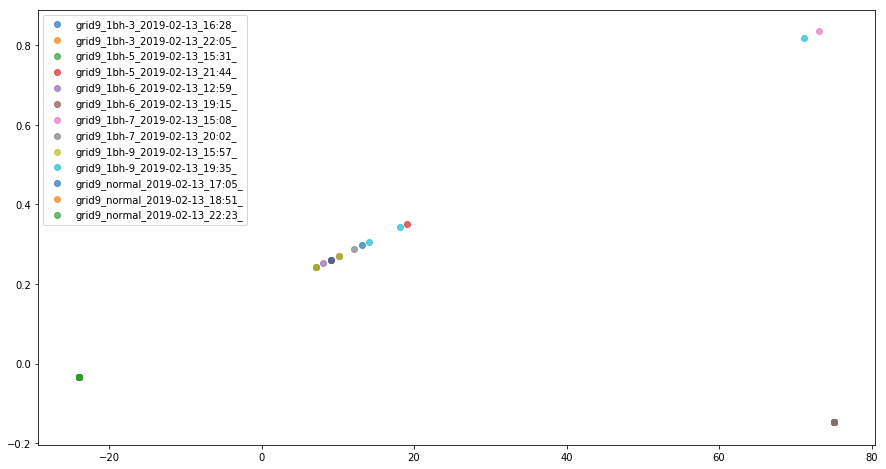

In [85]:
X = dataK.iloc[:,0:4]
pca = PCA(n_components=2)
pca.fit(X)
X_ = pca.transform(X)

dfPCA = pd.DataFrame({'x1': X_[:,0], 'x2': X_[:,1]})
dfPCA['labels'] = stats['label']
dfPCA.head()

labels = stats['label'].unique().tolist()
plt.figure(figsize=(15,8))
for lab in labels:
    plt.scatter(dfPCA.loc[dfPCA['labels'] == lab, 'x1'],  dfPCA.loc[dfPCA['labels'] == lab, 'x2'], label=lab, alpha=0.7)
    plt.legend()

<Figure size 1080x576 with 0 Axes>

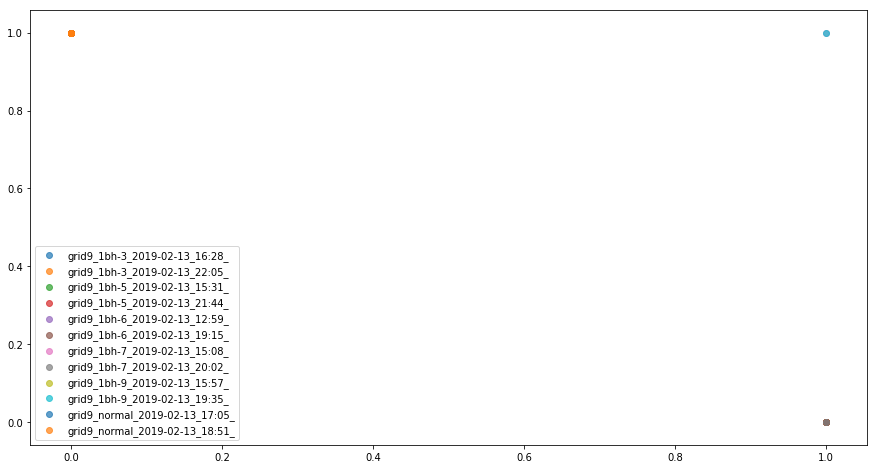

In [48]:
x= stats["packet loss"]
y=stats["var"]
plt.figure(figsize=(15,8))
labels = stats['label'].unique().tolist()
plt.figure(figsize=(15,8))
for lab in labels:
    plt.scatter(stats.loc[stats['label'] == lab, 'packet loss'],  stats.loc[stats['label'] == lab, 'std'], label=lab, alpha=0.7)
    plt.legend()